# Resources 
To go along with this walk through I recommend reading chapter 3 of ISLR, available here: http://www-bcf.usc.edu/~gareth/ISL/index.html

---

# Table of Contents 
### Chapter 4
* [4.1 Overview of Classification](#overview)
* [4.2 Why Not Linear Legression](#linear-regression)
* [4.3 Logistic Regression](#logistic-regression)
    * [4.3.1 The Logistic Model](#logistic-model)
    * [4.3.2 Estimating the Regression Coefficients](#regression-coeff)
            
---

# Key Terms
Here is a list of key terms that you can `cmd+f` to learn a bit more about. 
* classification
* categorical
* logistic regression
* K-nearest neighbor
* linear discriminant analysis
* maximum likelihood
* odds
* logit 
* log-odds
* sigmoid

# 4.1 Overview of Classification <a class="anchor" id="overview"></a>
The linear regression model discussed in Chapter 3 assumes that the response variable Y is quantitative. But in many situations, the response variable is instead qualitative (example: eye color can be brown, blue, or green). Often qualitative variables are referred to as **categorical**. 

In this walk through we will look at different approaches for predicting a qualitative response, a process known as **classification**. 

Predicting a qualitative response for an observation can be referred to as classifying that observation, since it involves assigning the observation to a category, or class. 

On the other hand, often the methods used for classification first predict the probability of each of the categories of a qualitative variable, as the basis for making the classification. In this sense they also behave like regression methods!

In this walk through, we are going to discuss 3 of the most commonly used classifiers:
* Logistic Regression
* Linear Discriminant Analysis
* K-nearest neighbor

So lets start by getting a broad overview of the classification situation. Classification problems occur often, possibly even more often than regression problems. For example:

1. A person arrives at the emergency room with a set of symptoms that could possibly be attributed to one of three medical conditions. Which of the three conditions does the individual have?

2. An online banking service must be able to determine whether or not a transaction being performed on the site is fraudulent, on the basis of the user’s IP address, past transaction history, and so forth.

3. On the basis of DNA sequence data for a number of patients with and without a given disease, a biologist would like to figure out which DNA mutations are deleterious (disease-causing) and which are not.

Now, just as we did in the regression setting, in the classification setting we will also have a set of training observations: $(x_1,y_1),...,(x_n,y_n)$. Again, we want our classifier to perform well not only on the training data, but also on test observations that were not used to train the classifier- in other words it must be able to generalize well to new examples!

We will illustrate the concept of classification using the simulated *Default* data set. We are interested in predicting whether an individual will default on his or her credit card payment, on the basis of annual income and monthly credit card balance. In other words, we will predict **yes they will default** or **no they will not default**, given **two input features**, **Balance** and **Income**. 

The data set is displayed in the figure below. We have plotted annual income and monthly credit card balance for a subset of 10,000 individuals. The left-hand panel displays individuals who defaulted in a given month in orange, and those who did not in blue. (The overall default rate is about 3%, so we have plotted only a fraction of the individuals who did not default.) 

What can we already gather from the visualization? *It appears that individuals who defaulted tended to have higher credit card balances than those who did not.*

In the right-hand panel below, two pairs of boxplots are shown. The first shows the distribution of balance split by the binary default variable; the second is a similar plot for income. 

In this walk through, we learn how to build a model to predict **default ($Y$)** for any given value of balance $(X_1)$ and income $(X_2)$. Since $Y$ is not quantitative, the simple linear regression model of Chapter 3 is not appropriate.

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# In R, I exported the dataset from package 'ISLR' to an Excel file
df = pd.read_excel('Default.xlsx')

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

  default student      balance        income  default2  student2
1      No      No   729.526495  44361.625074         0         0
2      No     Yes   817.180407  12106.134700         0         1
3      No      No  1073.549164  31767.138947         0         0

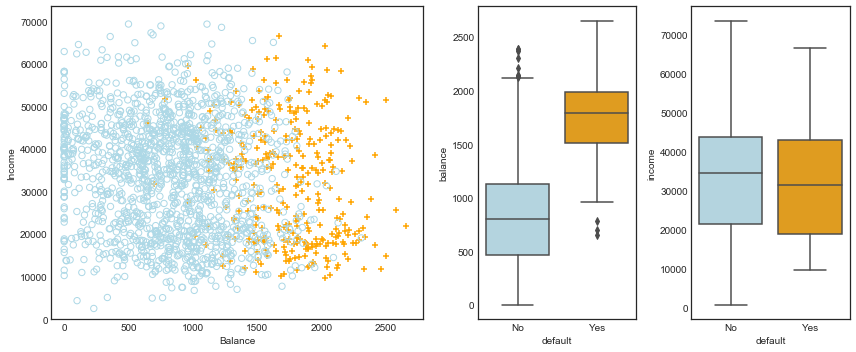

In [3]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]
df_ = df_no.append(df_yes)

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='none')

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())


It is worth noting that the figure above displays a very pronounced relationship between the predictor balance and the response default. In most real applications, the relationship between the predictor and the response will not be nearly so strong. However, for the sake of illustrating the classification procedures discussed in this chapter, we use an example in which the relationship between the predictor and the response is somewhat exaggerated.

# 4.2 Why Not Linear Regression? <a class="anchor" id="linear-regression"></a>
Okay, so now that we have gone over that linear regression is not appropriate in the case of a qualitative response. But we haven't talked about **why**. 

Lets look at an example. Suppose that we are trying to predict the medical condition of a patient in the emergency room on the basis of her symptoms. In this simplified example, there are three possible diagnoses: 
1. stroke 
2. drug overdose 
3. epileptic seizure. 
We could consider encoding these values as a quantitative response variable $Y$, as follows:

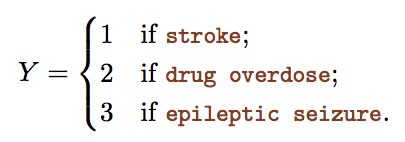

Using the above coding, we could use *least squares* to fit a linear regression model to predict $Y$ on the basis of a set of predictors $X_1,...,X_p$. However, this coding implies an ordering to the outcomes, putting **drug overdose** in between **stroke** and **epileptic seizure**, and insisiting that the difference between stroke and drug overdose is the same as the difference between drug overdose and epileptic seizure. In practice, there is no real reason for this to be the case. For instance, you could choose an equally reasonable coding:

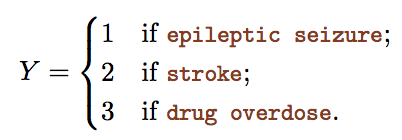

which would imply a totally different relationship among the three conditions. Each of these codings would produce fundamentally different linear models that would ultimately lead to different sets of predictions on test observations!

If the response variable’s values did take on a natural ordering, such as *mild, moderate, and severe*, and we felt the gap between *mild and moderate* was similar to the gap between *moderate and severe*, then a 1, 2, 3 coding would be reasonable. Unfortunately, in general there is no natural way to convert a qualitative response variable with more than two levels into a quantitative response that is ready for linear regression.

For a binary (two level) qualitative response, the situation is better. For instance, perhaps there are only two possibilities for the patient’s medical condition: stroke and drug overdose. We could then potentially use the dummy variable approach from the linear regression walk through to code the response as follows:

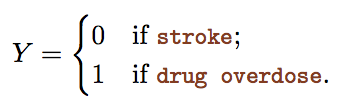

We could then fit a linear regression to this binary response, and predict drug overdose if $\hat{Y} > 0.5$ and stroke otherwise. In the binary case it is not hard to show that even if we flip the above coding, linear regression will produce the same final predictions.

For a binary response with a 0/1 coding as above, regression by least squares **does make sense**; it can be shown that the $X\hat{\beta}$ obtained using linear regression is in fact an estimate of $Pr(drug\;overdose\;|\;X)$ (probability of drug overdose given X) in this special case. However, if we use linear regression, some of our estimates might be outside the [0, 1] interval (see figure 4.2 below), **making them hard to interpret as probabilities!** Nevertheless, the predictions provide an ordering and can be interpreted as crude probability estimates.

## Figure 4.2

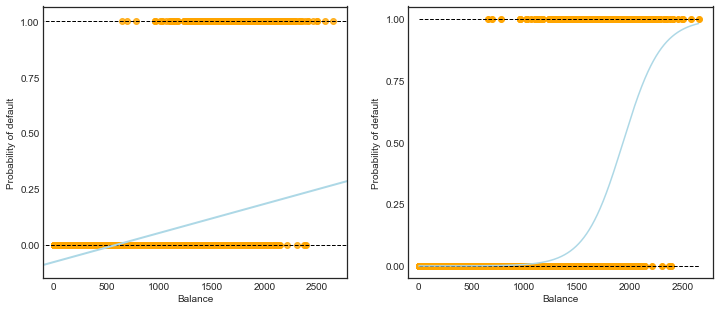

In [4]:
X_train = df.balance.values.reshape(-1,1) 
y = df.default2

# Create array of test data. Calculate the classification probability
# and predicted classification.
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y)
prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot
sns.regplot(df.balance, df.default2, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)


However, the dummy variable approach cannot be easily extended to accommodate qualitative responses with more than two levels. For these reasons, it is preferable to use a classification method that is truly suited for qualitative response values, such as the ones presented next.

# 4.3 Logistic Regression <a class="anchor" id="logistic-regression"></a>
Okay, so now I want us to take a look at the Default data set again. See how the response **default** falls into two categories, **Yes** or **No**. Rather than modeling this response $Y$ directly, logistic regression models the **probability** that $Y$ belongs to a particular category! 


For the Default data, logistic regression models the probability of that a person will default. For example, the probability that a person will default given balance can be written as:
### $$Pr(default = Yes\;|\;balance)$$
The values of $Pr(default = Yes\;|\;balance)$, which we will abbreviate $p(balance)$ (where p is a probability function based on the parameter balance), will range between 0 and 1. Then, for any given **balance**, a prediction can be made for whether the user will default or not. 

For example, one might predict $default = Yes$ for any individual for whom $p(balance) > 0.5$

Alternatively, if a company wishes to be conservative in predicting individuals who are at risk for default, then they may choose to use a lower threshold, such as $p(balance) > 0.1$.

## 4.3.1 The Logistic Model <a class="anchor" id="logistic-model"></a>
Okay so the question now arises: how should we model the relationship between:
### $$p(X) = Pr(Y=\;1|\;X)$$ 
and:
### $$X$$

In other words how do we model how the probability that Y = 1 (a person does default) based on their balance?

We have already talked about the idea of using the linear regression model to represent these probabilities:
### $$p(X) = \beta_0 + \beta_1X$$
If we use this approach to predict default=Yes using balance, then we obtain the model shown in the left-hand panel of Figure 4.2. Here we see the problem with this approach: for balances close to zero we predict a negative probability of default; if we were to predict for very large balances, we would get values bigger than 1. These predictions are not sensible, since of course the true probability of default, regardless of credit card balance, must fall between 0 and 1.

This problem is not unique to the credit default data. Any time a straight line is fit to a binary response that is coded as 0 or 1, in principle we can always predict p(X) < 0 for some values of X and p(X) > 1 for others (unless the range of X is limited).

To avoid this problem, we must model p(X) using a function that gives outputs between 0 and 1 for all values of X. Many functions meet this description. In logistic regression, we use the logistic function:

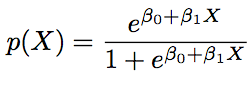

Remember, this is the same formula as the one we saw for the hypothesis in the machine learning walk through on logistic regression. 

To fit this model, we will use a method called **maximum likelihood**, which we discuss in the next section. 

The right-hand panel of Figure 4.2 illustrates the fit of the logistic regression model to the Default data. Notice that for low balances we now predict the probability of default as close to, but never below, zero. Likewise, for high balances we predict a default probability close to, but never above, one. The logistic function will always produce an S-shaped curve of this form, and so regardless of the value of X, we will obtain a sensible prediction.

We also see that the logistic model is better able to capture the range of probabilities than is the linear regression model in the left-hand plot. The average fitted probability in both cases is 0.0333 (averaged over the training data), which is the same as the overall proportion of defaulters in the data set.

Now if we manipulate the logistic formula above we can see that:

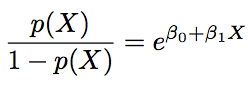

This quantity is known as the **odds**, and can take on any value between zero and infinity. Values of the odds close to 0 and ∞ indicate very low and very high probabilities of default, respectively. 

For example, on average 1 in 5 people with an odds of 1/4 will default, since p(X) = 0.2 implies an
odds of 0.2/(1-0.2) = 1/4. Likewise on average nine out of every ten people with an odds of 9 will default, since p(X) = 0.9 implies an odds of 0.9/(1−0.9) = 9. Odds are traditionally used instead of probabilities in horse-racing, since they relate more naturally to the correct betting strategy.

If we take the logarithm of both sides, we arrive at: 

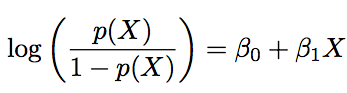

The left-hand side is called the **log-odds** or **logit**. We see that the logistic regression model has a logit that is linear in X.

Recall from Chapter 3 (linear regression walk through) that in a linear regression model, $\beta_1$ gives the average change in Y associated with a one-unit increase in X. 

In contrast, in a logistic regression model, increasing X by one unit changes the log odds by β1 (4.4), or equivalently it multiplies the odds by $e^{\beta_1}$. However, because the relationship between p(X) and X in the logistic function is not a straight line, $\beta_1 does **not** correspond to the change in p(X) associated with a one-unit increase in X. The amount that p(X) changes due to a one-unit change in X will depend on the current value of X0-because it is not linear so slope is dependent on *position*!

But regardless of the value of X, if β1 is positive then increasing X will be associated with increasing p(X), and if β1 is negative then increasing X will be associated with decreasing p(X). The fact that there is not a straight-line relationship between p(X) and X, and the fact that the rate of change in p(X) per unit change in X depends on the current value of X, can also be seen by inspection of the right-hand panel of Figure 4.2.

## Background on the Odds
The question may still be coming up (it was for me) in your mind: "how do I interpret the Odds Ratios in Logistic Regression?"

When a binary outcome variable is modeled using logistic regression, it is assumed that the logit transformation of the outcome variable has a linear relationship with the predictor variables.  This makes the interpretation of the regression coefficients somewhat tricky.  Let's walk through the concept of odds ratio and try to interpret the logistic regression results using the concept of odds ratio in a couple of examples.

### From probability to odds to log of odds
#### First: probability -> odds
Everything starts with the concept of probability.  Let’s say that the probability of success of some event is:
### $$0.8$$  
Then the probability of failure is:
### $$1 - 0.8 = 0.2$$
The **odds of success** are defined as the ratio of the **probability of success** over the **probability of failure**:
### $$odds\;of\;success = \frac{probability\;of\;success}{probability\;of\;failure}$$
In our example, the odds of success are:
### $$\frac{0.8}{0.2} = 4$$
This means that the odds of success are 4 to 1. If the probability of success is 0.5, (i.e. a 50-50% chance), then the odds of success is: 1 to 1
### $$\frac{0.5}{0.5} = 1$$
The transformation from probability to odds is a monotonic transformation, meaning the odds increase as the probability increases or vice versa. Probability ranges from 0 and 1.  Odds range from 0 and positive infinity.  Below is a table of the transformation from probability to odds and we have also plotted for the range of p less than or equal to .9.

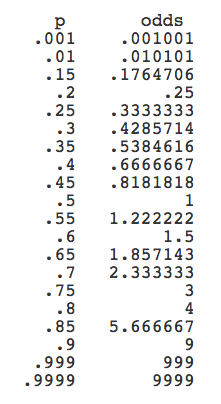

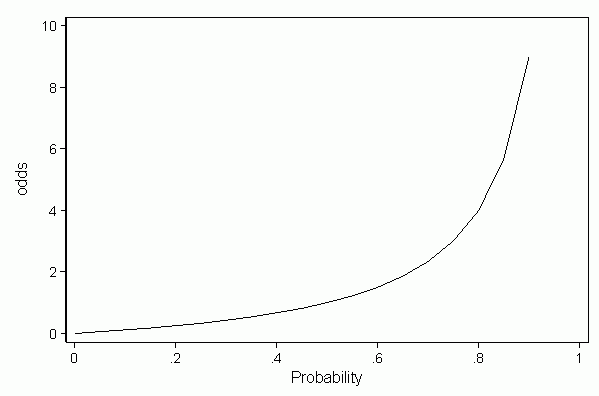

#### Second: odds -> log of odds
The transformation from **odds** to **log of odds** is the log transformation.  Again this is a monotonic transformation.  That is to say, the greater the odds, the greater the log of odds and vice versa. The table below shows the relationship among the probability, odds and log of odds.  We have also shown the plot of log odds against odds.

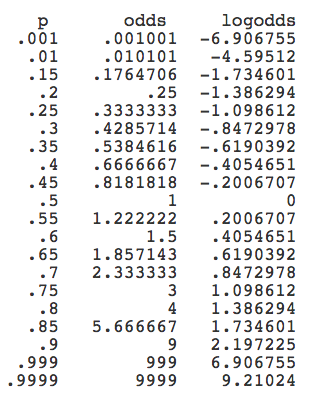

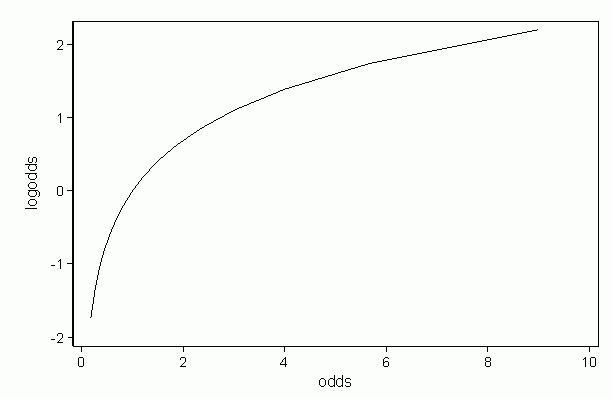

Okay, so now we can clearly see how we arrive at the log odds mechanically, but the question still remains: *why* do we take all the trouble of doing this transformation?? 
* One reason is that it is usually difficult to model a variable which has restricted range, such as probability.  This transformation is an attempt to get around the restricted range problem.  It maps probability ranging between 0 and 1 to log odds ranging from negative infinity to positive infinity.
* Another reason is that among all of the infinitely many choices of transformation, the log of odds is one of the easiest to understand and interpret.  This transformation is called **logit transformation.**

A logistic regression model allows us to establish a relationship between a binary outcome variable and a group of predictor variables.  It models the logit-transformed probability as a linear relationship with the predictor variables. (continue reading more at here: https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/)

## Background on the Logit
Now that we went over the **odds** and touched on the **logit**, lets go over the logit in more detail. 

So, remember, the logit (L) of a probability (p) is defined as:
### $$Logit = ln\big(\frac{probability}{1-probability}\big)= ln\big(\;\frac{probability\;of\;success}{probability\;of\;failure}\big)$$
or simplified:
### $$L = ln\big(\frac{p}{1-p}\big)$$
the term:
### $$\frac{p}{1-p}$$
is called the **odds** (always intuitively think probability of success over failure). 

If we then try and solve for p, we find: 
### $$p = \frac{e^L}{1+e^L} = \frac{1}{1+e^{-L}}$$
Note that this is exactly what we saw earlier in this walk through, as in:

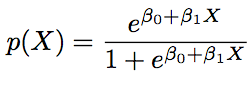

Okay, so now that we have gotten to that point, lets think about this. Probabilities can range from zero to one, whereas logits can be any real number. 

A probability of 0.50.5 corresponds to a logit of 0. Negative logit values indicate probabilities smaller than 0.5, positive logits indicate probabilities greater than 0.5. The relationship is symmetrical: Logits of −0.2−0.2 and 0.2 correspond to probabilities of 0.45 and 0.55, respectively. Note: The absolute distance to 0.5 is identical for both probabilities.

Here is the non-linear relationship between logits and probabilities:

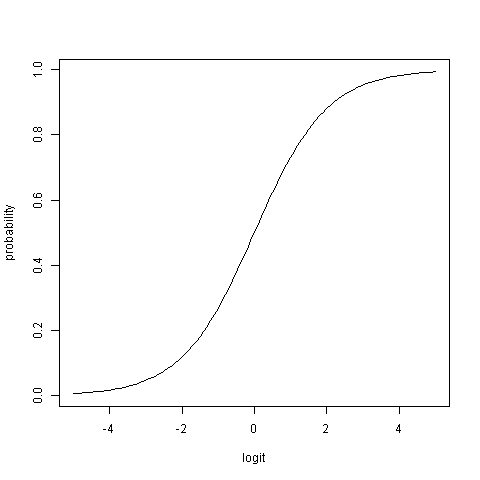

## Background: Logit and Sigmoid Functions
Lets try and relate back to what we learned in the machine learning lecture for logistic regression and the sigmoid function. 

Again, if we are given a probability p, the corresponding odds are calculated as:
### $$\frac{p}{1-p}$$

The **logit function** is simply the logarithm of the odds! 

Below is a plot of the logit function:

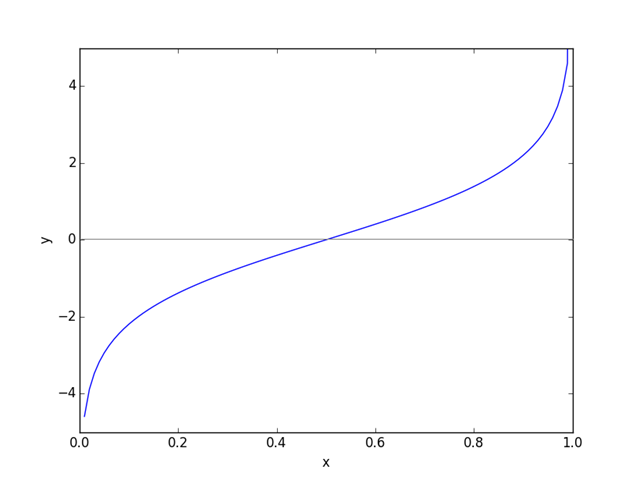

The value of the logit function heads towards infinity as p approaches 1 and towards negative infinity as it approaches 0.

Remember, we want to be asking **why** we are using the logit function! Well, the main reason is because the logit function maps probabilities (which are values in the range [0, 1]) to the full range of real numbers! In particular, if you are working with “yes-no” (binary) inputs it can be useful to transform them into real-valued quantities prior to modeling. This is essentially what happens in logistic regression.

This is where the sigmoid function comes in-the inverse of the logit function is the sigmoid function! 

So, if we remember the logit is:
### $$Logit = ln\big(\frac{p}{1-p}\big)$$
and the sigmoid is defined as:
### $$\sigma(x) = \frac{1}{1+e^{-x}}$$
then the sigmoid in our case respectively becomes:
### $$sigmoid(logit(p)) = p = \frac{1}{1+e^{-logit(p)}}= \frac{1}{1+e^{-\frac{p}{1-p}}}$$ 

Below is a plot of the sigmoid function:

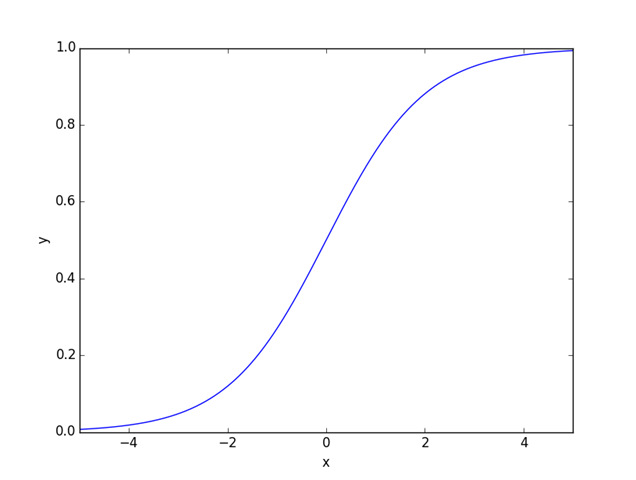

The sigmoid might be useful if you want to transform a real valued variable into something that represents a probability, which is exactly what we did in the logistic regression machine learning walkthrough. 

The term “sigmoid function” is used to refer to a class of functions with S-shaped curves. In most machine learning contexts, “sigmoid” usually refers specifically to the function described above.)

There are other functions that map probabilities to reals (and vice-versa), so what’s so special about the logit and sigmoid? One reason is that the logit function has the nice connection to odds described at the beginning of the article. A second is that the gradients of the logit and sigmoid are simple to calculate (try it and see). The reason why this is important is that many optimization and machine learning techniques make use of gradients, for example when estimating parameters for a neural network.

## Main intution to remember!
* The logit function maps probabilities in range 0-1 to real numbers ranging from negative infinity to positive infinity
* The sigmoid function maps aribitrary real values to the range 0-1 (aka a probability)

## 4.3.2 Estimating the Regression Coefficients <a class="anchor" id="regression-coeff"></a>